<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Gender-Analysis" data-toc-modified-id="Gender-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gender Analysis</a></span><ul class="toc-item"><li><span><a href="#Computing-Gender-Screen-Time" data-toc-modified-id="Computing-Gender-Screen-Time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Computing Gender Screen Time</a></span></li><li><span><a href="#Gender-Screen-Time-in-Our-Dataset" data-toc-modified-id="Gender-Screen-Time-in-Our-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Gender Screen Time in Our Dataset</a></span></li><li><span><a href="#Changes-in-gender-representation-over-time" data-toc-modified-id="Changes-in-gender-representation-over-time-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Changes in gender representation over time</a></span></li><li><span><a href="#Gender-Representation-by-Genre" data-toc-modified-id="Gender-Representation-by-Genre-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Gender Representation by Genre</a></span></li><li><span><a href="#Shot-Duration-by-Gender" data-toc-modified-id="Shot-Duration-by-Gender-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Shot Duration by Gender</a></span></li></ul></li></ul></div>

In [2]:
from query.models import Video, Shot, Labeler, Face, FaceGender, Genre
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from django.db.models import Avg, Sum
from tqdm import tqdm
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.merge_ops import payload_plus
from rekall.parsers import in_array, merge_dict_parsers, dict_payload_parser
from rekall.temporal_predicates import overlaps
from rekall.payload_predicates import payload_satisfies
import numpy as np

# Gender Analysis

In this notebook we'll be conducting some analyses of gender screen time ratios (male vs female screentime) over the film dataset. We will exclude all animated films.

## Computing Gender Screen Time
Faces are computed at 2 FPS and at every microshot boundary. To avoid weird edge cases at the microshot boundaries, we'll only compute statistics at the 2 FPS sampling.

In [3]:
all_videos = Video.objects.filter(decode_errors=False).exclude(genres__name='animation').order_by('id').all()

In [4]:
# Takes about six and a half minutes to run!
# Load all FaceGender data into Rekall. faces_with_gender has one interval per face.
facegender_qs = FaceGender.objects.filter(
    face__frame__video__in=all_videos,
    labeler__name="gender-knn"
).annotate(
    min_frame=F('face__frame__number'),
    max_frame=F('face__frame__number'),
    video_id=F('face__frame__video_id'),
    gender_name=F('gender__name'),
    face_probability=F('face__probability')
).all()

total_faces = facegender_qs.count()

faces_with_gender = VideoIntervalCollection.from_django_qs(
    facegender_qs,
    with_payload=merge_dict_parsers([
        dict_payload_parser(VideoIntervalCollection.django_accessor, { 'face_id': 'face_id' }),
        dict_payload_parser(VideoIntervalCollection.django_accessor, { 'gender': 'gender_name' }),
        dict_payload_parser(VideoIntervalCollection.django_accessor, { 'gender_probability': 'probability' }),
        dict_payload_parser(VideoIntervalCollection.django_accessor, { 'face_probability': 'face_probability' })
    ]),
    progress=True,
    total=total_faces
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8529081/8529081 [03:44<00:00, 37910.22it/s]


In [5]:
# For the faces where we have identity mappings, annotate them with gender
facecharacteractor_qs = FaceCharacterActor.objects.annotate(
    actor_id=F('characteractor__actor_id')
).all()
actor_ids = set([
    fca.actor_id
    for fca in facecharacteractor_qs
])
actorgender_qs = ActorGender.objects.filter(
    actor_id__in=actor_ids
).annotate(
    gender_name = F('gender__name')
)
face_to_actor = {
    fca.face_id: fca.actor_id
    for fca in facecharacteractor_qs
}
actor_to_gender = {
    ag.actor_id: ag.gender_name
    for ag in actorgender_qs
}
face_to_gender = {
    face: actor_to_gender[face_to_actor[face]]
    for face in face_to_actor if face_to_actor[face] in actor_to_gender
}

In [6]:
len(face_to_gender)

688791

In [7]:
faces_with_gender = faces_with_gender.map(
    lambda intrvl: (
        intrvl.start, intrvl.end,
        {
            'face_id': intrvl.payload['face_id'],
            'face_probability': intrvl.payload['face_probability'],
            'gender': (
                intrvl.payload['gender']
                if intrvl.payload['face_id'] not in face_to_gender
                else face_to_gender[intrvl.payload['face_id']]),
            'gender_probability': (
                intrvl.payload['gender_probability']
                if intrvl.payload['face_id'] not in face_to_gender
                else 1.0)
        }
    )
)

In [54]:
def compute_gender_ratio_for_video(intervallist):
    male_time = intervallist.fold(lambda acc, intrvl: (
        acc + (intrvl.get_payload()['gender_probability'] if
              intrvl.get_payload()['gender'] == 'M' else
               (1 - intrvl.get_payload()['gender_probability'])
              )# * intrvl.get_payload()['face_probability']
    ), 0.)
    female_time = intervallist.fold(lambda acc, intrvl: (
        acc + (intrvl.get_payload()['gender_probability'] if
              intrvl.get_payload()['gender'] == 'F' else
               (1 - intrvl.get_payload()['gender_probability'])
              )# * intrvl.get_payload()['face_probability']
    ), 0.)
    
#     male_time = intervallist.filter(
#         payload_satisfies(lambda payload: payload['gender'] == 'M')
#     ).fold(lambda acc, intrvl: (acc + 
#                                 intrvl.get_payload()['gender_probability'] * 
#                                 intrvl.get_payload()['face_probability']), 0.)
#     female_time = intervallist.filter(
#         payload_satisfies(lambda payload: payload['gender'] == 'F')
#     ).fold(lambda acc, intrvl: (acc + 
#                                 intrvl.get_payload()['gender_probability'] * 
#                                 intrvl.get_payload()['face_probability']), 0.)
    
    return male_time / (male_time + female_time), female_time / (male_time + female_time)

In [55]:
videos_with_gender_ratios = [
    (video, compute_gender_ratio_for_video(faces_with_gender.get_intervallist(video.id)))
    for video in tqdm(all_videos)
]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 602/602 [00:11<00:00, 50.38it/s]


In [10]:
# For sanity checking, remove films calssified as fantasy (old men with long hair) or family (young kids)
videos_no_family_fantasy = Video.objects.filter(decode_errors=False).exclude(
    genres__name__in=['animation', 'family', 'fantasy']
)
videos_with_gender_ratios_no_family_fantasy = [
    (video, compute_gender_ratio_for_video(faces_with_gender.get_intervallist(video.id)))
    for video in tqdm(videos_no_family_fantasy)
]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 533/533 [00:14<00:00, 37.06it/s]


## Gender Screen Time in Our Dataset

In [11]:
# Let's plot histograms of male and female screen time
def plot_male_female_screen_time_histograms(videos_with_gender_ratios):
    male_screen_time = sorted([m for v, (m, f) in videos_with_gender_ratios])
    female_screen_time = sorted([f for v, (m, f) in videos_with_gender_ratios])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist([male_screen_time, female_screen_time], [i * .01 for i in range(100)], histtype='bar',
             label=['Male Screen Time', 'Female Screen Time'], color=['y', 'g'])
    ax.legend()
    ax.set_title('Histogram of male and female screen time')
    plt.show()

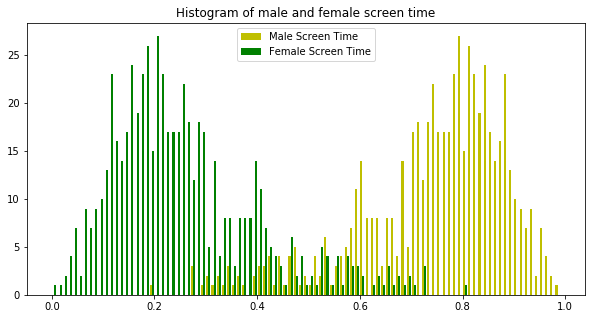

In [56]:
plot_male_female_screen_time_histograms(videos_with_gender_ratios)

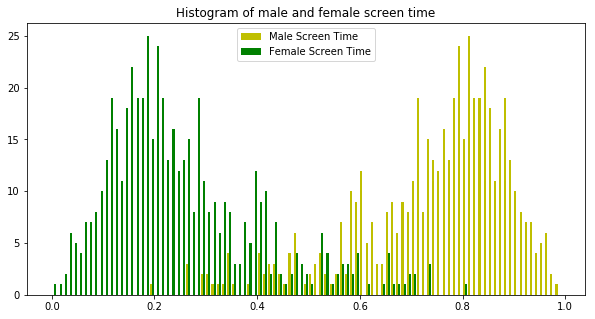

In [13]:
plot_male_female_screen_time_histograms(videos_with_gender_ratios_no_family_fantasy)

In [14]:
# What about overall male/female screen time?
def plot_average_male_female_screen_time(videos_with_gender_ratios):
    male_screen_time = [np.mean([m for v, (m, f) in videos_with_gender_ratios])]
    female_screen_time = [np.mean([f for v, (m, f) in videos_with_gender_ratios])]
    
    names = ['Average Screen Time']
    N = len(names)

    ax = plt.gca()
    
    width = 0.35
    ind = np.arange(N)
    p1 = ax.bar(ind, male_screen_time, width, color='y')
    p2 = ax.bar(ind + width, female_screen_time, width, color='g')
    
    ax.set_title('Average Male/Female Screen Time')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    ax.set_ylabel('Average Screen Time')
    ax.set_ylim((0, 1))
    
    ax.legend((p1[0], p2[0]), ('Male Screen Time', 'Female Screen Time'))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%f' % height,
                    ha='center', va='bottom')

    autolabel(p1)
    autolabel(p2)
    
    plt.show()

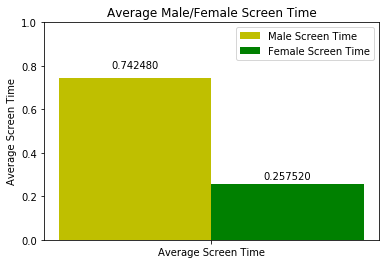

In [57]:
plot_average_male_female_screen_time(videos_with_gender_ratios)

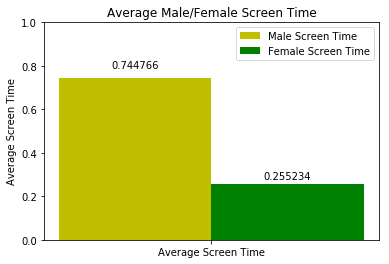

In [58]:
plot_average_male_female_screen_time(videos_with_gender_ratios_no_family_fantasy)

## Changes in gender representation over time

In [40]:
def movingaverage(x, y, window_size):
    return [
        np.mean([y2 for x2, y2 in zip(x, y) if abs(x2-x1) <= window_size])
        for x1 in x
    ]

# Plot male ratios by year
def plot_male_gender_ratios_by_year(videos_with_gender_ratios, min_year=None):
    data = sorted([(v.year, male_ratio) for v, (male_ratio, female_ratio) in videos_with_gender_ratios])
    if min_year is not None:
        data = [d for d in data if d[0] >= min_year]
        
    x = [d[0] for d in data]
    y = [d[1] for d in data]
    y_av = movingaverage(x, y, 10)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(x, y, s=3, color='y')
    ax.plot(x, y_av, color='r')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Year')
    ax.set_ylabel('Male Screen Time Percentage')
    ax.set_title('Male Screen Time Percentage Over Time')
    
    #ax.set_yscale('symlog')
    
#     ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 3))(np.unique(x)))
#     ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='y')
    plt.show()
    
# Plot male ratios by year
def plot_female_gender_ratios_by_year(videos_with_gender_ratios, min_year=None, filename=None):
    data = sorted([(v.year, female_ratio) for v, (male_ratio, female_ratio) in videos_with_gender_ratios])
    if min_year is not None:
        data = [d for d in data if d[0] >= min_year]
        
    x = [d[0] for d in data]
    y = [100. * d[1] for d in data]
    y_av = movingaverage(x, y, 10)
    
    fig, ax = plt.subplots(figsize=(6.666, 3.333))
    ax.scatter(x, y, s=3, color='k')
    ax.plot(x, y_av, color='r')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Year')
    ax.set_xticks(range(1915, 2016, 25))
    ax.set_yticks(range(0, 101, 20))
    ax.set_ylabel('Female Screen Time Percentage')
    ax.set_title('Female Screen Time Percentage Over Time')
    
    #ax.set_yscale('symlog')
    
#     ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 3))(np.unique(x)))
#     ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='g')
    if filename is not None:
        plt.savefig(filename)
    plt.show()

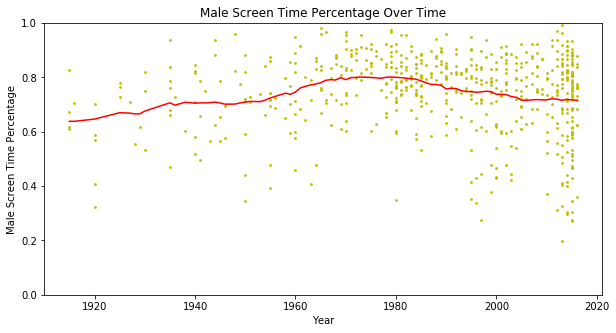

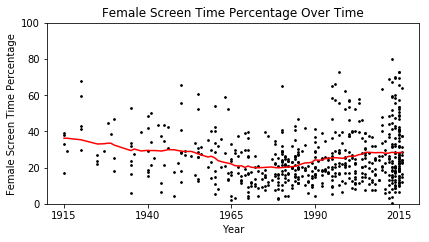

In [59]:
plot_male_gender_ratios_by_year(videos_with_gender_ratios)
plot_female_gender_ratios_by_year(videos_with_gender_ratios, filename="film_female_screen_time.pdf")

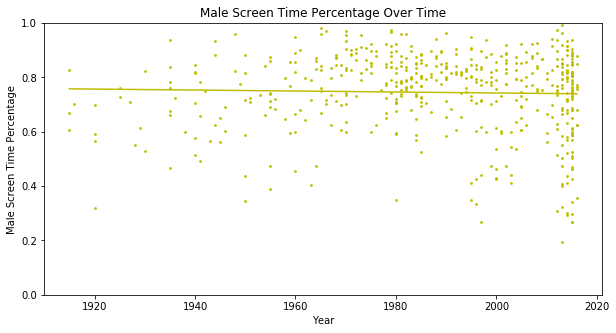

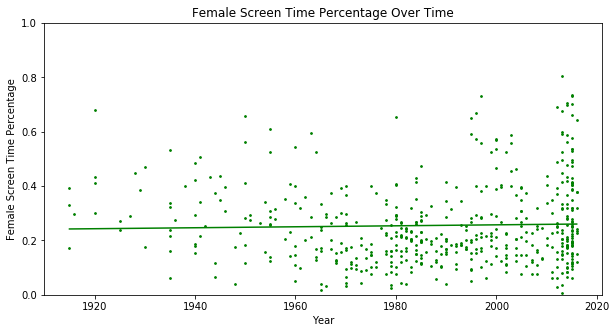

In [42]:
plot_male_gender_ratios_by_year(videos_with_gender_ratios_no_family_fantasy)
plot_female_gender_ratios_by_year(videos_with_gender_ratios_no_family_fantasy)

In [60]:
# What videos have exceptionally high male screen times (low female screen times)?
sorted([
    (v.title, v.year, male_screen_time)
    for v, (male_screen_time, female_screen_time) in videos_with_gender_ratios if male_screen_time > .95
], key=lambda tup: (tup[2], tup[0], tup[1]))

[('Papillon', 1973, 0.9547376530000857),
 ('Tora! Tora! Tora!', 1970, 0.9555344927058428),
 ('Timon of Athens', 1981, 0.9572274853663697),
 ('First Blood', 1982, 0.9575611249022338),
 ('The Treasure of the Sierra Madre', 1948, 0.9587584541861657),
 ('The Hunt for Red October', 1990, 0.9595148247978443),
 ('For a Few Dollars More', 1965, 0.9595242961276068),
 ('Phantom', 2013, 0.9625561407678936),
 ('Royal Shakespeare Company: Henry IV Part II', 1979, 0.9656699889258028),
 ("Kelly's Heroes", 1970, 0.9672761234239731),
 ('The Good, the Bad and the Ugly', 1966, 0.9672946771538317),
 ('Killing Them Softly', 2012, 0.9703987223262472),
 ('Henry IV Part I', 1979, 0.9743331492251208),
 ('The Flight of the Phoenix', 1965, 0.9809029387225366),
 ('Locke', 2013, 0.9934593602935311)]

In [61]:
# What videos have exceptionally low male screen times (high female screen times)?
sorted([
    (v.title, v.year, male_screen_time)
    for v, (male_screen_time, female_screen_time) in videos_with_gender_ratios if male_screen_time < .50
], key=lambda tup: (tup[2], tup[0], tup[1]))

[('Gravity', 2013, 0.19949609473418986),
 ('Carol', 2015, 0.27232616672226057),
 ('Room', 2015, 0.2735070933685255),
 ("Romy and Michele's High School Reunion", 1997, 0.27404162497859214),
 ('Wild', 2014, 0.29860075972495903),
 ('Sisters', 2015, 0.3047407841332244),
 ('Still Alice', 2014, 0.30539137422417684),
 ('Mental', 2012, 0.3133636921414176),
 ('The Flapper', 1920, 0.3228435589766803),
 ('The Heat', 2013, 0.32691659785301336),
 ('The First Wives Club', 1996, 0.33823199894917844),
 ('Brooklyn', 2015, 0.3457054877378191),
 ('All About Eve', 1950, 0.3457591374214719),
 ('Nine to Five', 1980, 0.3497297191429353),
 ('Sense and Sensibility', 1995, 0.3512912890136133),
 ('The Forest', 2016, 0.3607912352827249),
 ('Alice in Wonderland', 2010, 0.3691013651510272),
 ('The Haunting', 1999, 0.37937058127699597),
 ('Diabolique', 1955, 0.3926326090162055),
 ('Into the Woods', 2014, 0.3990933285218092),
 ('Stoker', 2013, 0.4039757412398921),
 ('Pollyanna', 1920, 0.4076023913625414),
 ('The Bird

## Gender Representation by Genre

We have 22 different genres. How does gender representation differ for each?

In [64]:
# First, let's see how many films are in each genre
genres_and_counts = sorted([
    (g.name, Video.objects.filter(genres=g).count())
    for g in Genre.objects.all()
], key=lambda g_and_c: g_and_c[1])

In [65]:
genres_and_counts

[('short', 2),
 ('documentary', 2),
 ('film-noir', 9),
 ('sport', 10),
 ('music', 14),
 ('musical', 21),
 ('horror', 25),
 ('western', 26),
 ('animation', 32),
 ('war', 40),
 ('history', 47),
 ('biography', 48),
 ('family', 53),
 ('mystery', 65),
 ('fantasy', 82),
 ('crime', 96),
 ('romance', 102),
 ('sci-fi', 115),
 ('comedy', 185),
 ('action', 190),
 ('thriller', 208),
 ('adventure', 224),
 ('drama', 276)]

In [66]:
# Let's exclude animation, short, and documentary
genres = Genre.objects.exclude(name__in=['animation', 'short', 'documentary']).all()

In [79]:
def plot_gender_screen_time_by_genre(videos_with_gender_ratios, genres, title, filename=None):
    data = []
    for genre in genres:
        videos_in_genre = [v.id for v in Video.objects.filter(genres=genre).all()]
        male_screen_time = np.mean([m for v, (m, f) in videos_with_gender_ratios 
                                     if v.id in videos_in_genre])
        female_screen_time = np.mean([f for v, (m, f) in videos_with_gender_ratios 
                                     if v.id in videos_in_genre])
        data.append((male_screen_time, female_screen_time, genre.name))
    
    data = sorted(data)
    
    male_screen_times = [m * 100 for m, _, _ in data]
    female_screen_times = [f * 100 for _, f, _ in data]
    genres = [genre for _, _, genre in data]
    N = len(genres)

    fig, ax = plt.subplots(figsize=(6.666, 6.666))
    
    height = 0.35
    ind = np.arange(N)
    p1 = ax.barh(ind + height, male_screen_times, height)
    p2 = ax.barh(ind, female_screen_times, height)
    
    ax.set_title(title)
    ax.set_yticks(ind + height / 2)
    ax.set_yticklabels([g.capitalize() for g in genres])
    ax.set_xlim((0, 100))
    ax.set_ylabel('Genre')
    ax.set_xlabel('Screen time percentage')
    
    ax.legend((p1[0], p2[0]), ('Male Screen Time', 'Female Screen Time'), loc=4)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            width = rect.get_width()
            ax.text(width + .01, rect.get_y()-.2,
                    '%f Male' % width,
                    ha='left', va='bottom')

#     autolabel(p1)
#     autolabel(p2)

    if filename is not None:
        plt.savefig(filename)
    
    plt.show()

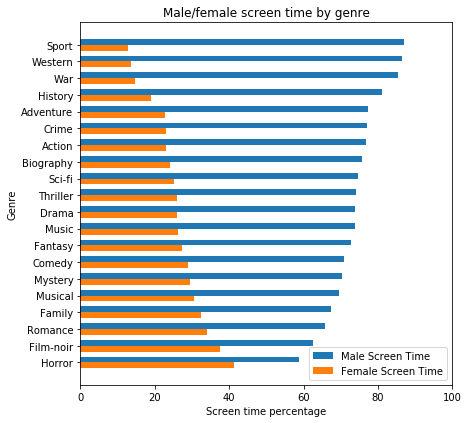

In [80]:
plot_gender_screen_time_by_genre(videos_with_gender_ratios, genres, 'Male/female screen time by genre',
                                filename='gender_screen_time_by_genre.pdf')

## Shot Duration by Gender
Do shot durations differ if they're primarily male or primarily female?

In [42]:
# First, load all the shots into Rekall
shots_qs = Shot.objects.filter(
    video__in=all_videos,
    labeler=Labeler.objects.get(name='shot-hsvhist-face')
).all()
num_shots = shots_qs.count()
shots = VideoIntervalCollection.from_django_qs(
    shots_qs,
    progress=True,
    total=num_shots
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834074/834074 [00:08<00:00, 100182.81it/s]


In [43]:
# Load shot scales into Rekall
frames_qs = Frame.objects.annotate(
    numbermod=F('number') % 12
).filter(numbermod=0, video_id__in=all_videos).annotate(
    shot_scale_name=F('shot_scale__name')
).all()
num_frames = frames_qs.count()
shot_scales = VideoIntervalCollection.from_django_qs(
    frames_qs,
    schema={
        "start": "number",
        "end": "number",
        "payload": "shot_scale_name"
    },
    progress=True,
    total=num_frames
)

KeyboardInterrupt: 

In [44]:
# Get the proportion of males in each frame
frames_with_male_proportion = faces_with_gender.map(
    lambda intrvl: (
        intrvl.start,
        intrvl.end,
        [intrvl.payload['gender_probability']
         if intrvl.payload['gender'] == 'M'
         else 1-intrvl.payload['gender_probability']])
).coalesce(payload_merge_op=payload_plus).map(
    lambda intrvl: (intrvl.start, intrvl.end, [intrvl.payload])
)

In [48]:
# Merge shots with frames_with_male_proportion to get shots that are >90% male or >90% female during the entire shot
shots_one_gender = shots.merge(
    frames_with_male_proportion,
    payload_merge_op=lambda shot_id, frame_male_proportion: frame_male_proportion,
    predicate=overlaps(),
    working_window=1
).coalesce(
    payload_merge_op=payload_plus
).filter(
    payload_satisfies(lambda gender_labels: (
        np.all([np.all([label > 0.9 for label in labels_per_frame]) for labels_per_frame in gender_labels]) or 
        np.all([np.all([label < 0.1 for label in labels_per_frame]) for labels_per_frame in gender_labels])
    ))
).map(
    lambda intrvl: (
        intrvl.start,
        intrvl.end,
        'M' if np.all([np.all([label > 0.9 for label in labels_per_frame]) for labels_per_frame in intrvl.payload]) else 'F')
)

In [49]:
# # Merge shots with one gender with shot scales
# # Next, overlap the shots with per-frame shot scales so that the payload
# #   for each shot is a list of all the shot scales in the shot
# # Finally, take the mode of the shot scales to get the scale of the whole shot
# def get_mode(objs, label):
#     items = [o[label] for o in objs]
#     return max(set(items), key=items.count)

# shots_with_scale_and_gender = shots_one_gender.merge(
#     shot_scales,
#     payload_merge_op=lambda gender, frame_shot_scale: [{'gender': gender, 'scales': frame_shot_scale}],
#     predicate=overlaps(),
#     working_window=1
# ).coalesce(
#     payload_merge_op=payload_plus
# ).map(
#     lambda shot_interval: (
#         shot_interval.get_start(),
#         shot_interval.get_end(),
#         {'gender': shot_interval.get_payload()[0]['gender'],
#          'scale': get_mode(shot_interval.get_payload(), 'scales') }
#     )
# )
shots_with_scale_and_gender = shots_one_gender.map(
    lambda intrvl: (intrvl.get_start(), intrvl.get_end(), { 'gender': intrvl.get_payload() })
)

In [50]:
# Normalized count of male shots vs. female shots
def plot_count_of_male_vs_female_shots(shots_with_scale_and_gender):
    male_proportions = [
        shots_with_scale_and_gender.get_intervallist(video_id).filter(payload_satisfies(
            lambda payload: payload['gender'] == 'M'
        )).size() / shots_with_scale_and_gender.get_intervallist(video_id).size()
        for video_id in list(shots_with_scale_and_gender.get_allintervals().keys())
    ]
    female_proportions = [
        1 - mp for mp in male_proportions
    ]
    
    names = ['Proportion of shot counts']
    N = len(names)

    ax = plt.gca()
    
    width = 0.35
    ind = np.arange(N)
    p1 = ax.bar(ind, [np.mean(male_proportions)], width, color='y')
    p2 = ax.bar(ind + width, [np.mean(female_proportions)], width, color='g')
    
    ax.set_title('Proportions of male/female shots')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    ax.set_ylabel('Average Proportion of Shots')
    ax.set_ylim((0, 1))
    
    ax.legend((p1[0], p2[0]), ('Male Shots', 'Female Shots'))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%f' % height,
                    ha='center', va='bottom')

    autolabel(p1)
    autolabel(p2)
    
    plt.show()

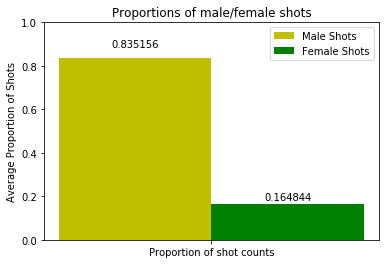

In [51]:
plot_count_of_male_vs_female_shots(shots_with_scale_and_gender)

In [52]:
# Normalized durations of male vs female shots
def plot_duration_of_male_vs_female_shots(shots_with_scale_and_gender):
    normalized_male_durations = []
    normalized_female_durations = []
    avg_durations = []
    
    for video_id in list(shots_with_scale_and_gender.get_allintervals().keys()):
        video = Video.objects.get(id=video_id)
        durations = []
        intrvllist = shots_with_scale_and_gender.get_intervallist(video_id)
        
        male_durations = []
        female_durations = []
        
        for intrvl in intrvllist.get_intervals():
            duration = intrvl.get_end() - intrvl.get_start()
            if intrvl.get_payload()['gender'] == 'M':
                male_durations.append(duration)
            else:
                female_durations.append(duration)
            durations.append(duration)
        
        if len(male_durations) > 0:
            normalized_male_durations.append(
                np.mean(male_durations) / np.mean(durations)
            )
        if len(female_durations) > 0:
            normalized_female_durations.append(
                np.mean(female_durations) / np.mean(durations)
            )
        
        avg_durations.append(np.mean(durations) / video.fps)
    
    avg_duration = np.mean(avg_durations)
    
    names = ['Average shot durations']
    N = len(names)

    ax = plt.gca()
    
    width = 0.35
    ind = np.arange(N)
    p1 = ax.bar(ind, [np.mean(normalized_male_durations) * avg_duration], width, color='y')
    p2 = ax.bar(ind + width, [np.mean(normalized_female_durations) * avg_duration], width, color='g')
    
    ax.set_title('Average durations of of male/female shots')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    ax.set_ylabel('Average Duration')
    ax.set_ylim((0, 6))
    
    ax.legend((p1[0], p2[0]), ('Male Shots', 'Female Shots'))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%f' % height,
                    ha='center', va='bottom')

    autolabel(p1)
    autolabel(p2)
    
    plt.show()

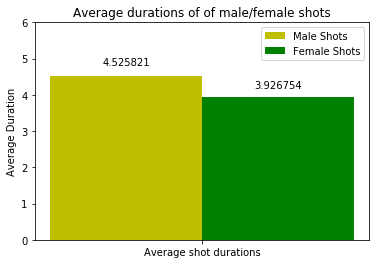

In [53]:
plot_duration_of_male_vs_female_shots(shots_with_scale_and_gender)

In [99]:
shot_scale_labels = ['extreme_long', 'long', 'medium_long', 'medium', 'medium_close_up',
             'close_up', 'extreme_close_up']

# Compute normalized shot durations for each category of shot
def compute_shot_scale_normalized_duration(shots_with_scale, gender_label):
    scale_proportions = {label: [] for label in shot_scale_labels}
    
    average_shot_duration_data = 0.
    total_videos = 0.
    
    for video_id in shots_with_scale.get_allintervals():
        scale_proportions_for_video = {label: [] for label in shot_scale_labels}
        avg_shot_durations_for_video = []
        
        shots_in_video = shots_with_scale.get_intervallist(video_id)
        
        video = Video.objects.get(id=video_id)
        
        for intrvl in shots_in_video.get_intervals():
            if intrvl.get_payload()['gender'] == gender_label:
                if intrvl.get_payload()['scale'] not in shot_scale_labels:
                    continue
                scale_proportions_for_video[intrvl.get_payload()['scale']].append(
                    intrvl.get_end()-intrvl.get_start()
                )
            avg_shot_durations_for_video.append(intrvl.get_end() - intrvl.get_start())
        
        avg_shot_duration_for_video = np.mean(avg_shot_durations_for_video)
        
        for label in shot_scale_labels:
            if len(scale_proportions_for_video[label]) > 0:
                scale_proportions[label].append(
                    np.mean(scale_proportions_for_video[label]) / avg_shot_duration_for_video
                )
        
        average_shot_duration_data += avg_shot_duration_for_video / video.fps
        total_videos += 1
    
    average_shot_duration_data /= total_videos
    
    normalized_proportions = [
        np.mean(scale_proportions[label]) * average_shot_duration_data
        for label in shot_scale_labels
    ]
    
    return normalized_proportions

In [88]:
def plot_duration_per_shot_scale(shot_scale_labels, shot_scale_distributions,
                                  distribution_labels, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    for distribution, label in zip(shot_scale_distributions, distribution_labels):
        x = range(0, len(shot_scale_labels))
        y = distribution
        ax.plot(x, y, label=label)
        
        ax.legend()
        
    ax.set_xlabel('Shot scale')
    ax.set_ylabel('Average duration (s)')
    ax.set_title(title)
    
    plt.xticks(x, shot_scale_labels)
    
    plt.show()

In [100]:
shot_scale_durations_male = compute_shot_scale_normalized_duration(shots_with_scale_and_gender, 'M')

In [101]:
shot_scale_durations_female = compute_shot_scale_normalized_duration(shots_with_scale_and_gender, 'F')

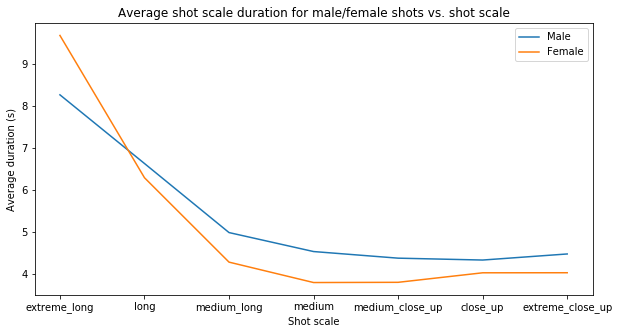

In [103]:
plot_duration_per_shot_scale(
    shot_scale_labels,
    [shot_scale_durations_male, shot_scale_durations_female],
    ['Male', 'Female'],
    'Average shot scale duration for male/female shots vs. shot scale'
)

In [104]:
def distribution_of_shot_scales(frames_with_shot_scale, gender_label):
    labels = ['extreme_long', 'long', 'medium_long', 'medium', 'medium_close_up',
             'close_up', 'extreme_close_up']
    
    shot_scale_proportions = {
        label: 0. for label in labels
    }
    total_videos = 0.
    
    for video_id in list(frames_with_shot_scale.get_allintervals().keys()):
        counts_for_video = {
            label: 0. for label in shot_scale_proportions
        }
        total_frames = 0.
        for intrvl in frames_with_shot_scale.get_intervallist(video_id).get_intervals():
            shot_scale = intrvl.payload['scale']
            if shot_scale not in labels:
                continue
            if intrvl.payload['gender'] == gender_label:
                counts_for_video[shot_scale] += 1
            total_frames += 1
        for label in counts_for_video:
            shot_scale_proportions[label] += counts_for_video[label] / total_frames
        total_videos += 1
    
    return labels, [shot_scale_proportions[label] / total_videos for label in labels]

In [105]:
def graph_shot_scale_distribution(shot_scale_labels, shot_scale_distributions,
                                               distribution_labels, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    for distribution, label in zip(shot_scale_distributions, distribution_labels):
        x = range(0, len(shot_scale_labels))
        y = distribution
        ax.plot(x, y, label=label)
        
        ax.legend()
        
    ax.set_xlabel('Shot scale')
    ax.set_ylabel('Proportion of frames')
    ax.set_title(title)
    
    plt.xticks(x, shot_scale_labels)
    
    plt.show()

In [108]:
_, shot_scale_distribution_all_videos_male = distribution_of_shot_scales(shots_with_scale_and_gender, 'M')

In [109]:
_, shot_scale_distribution_all_videos_female = distribution_of_shot_scales(shots_with_scale_and_gender, 'F')

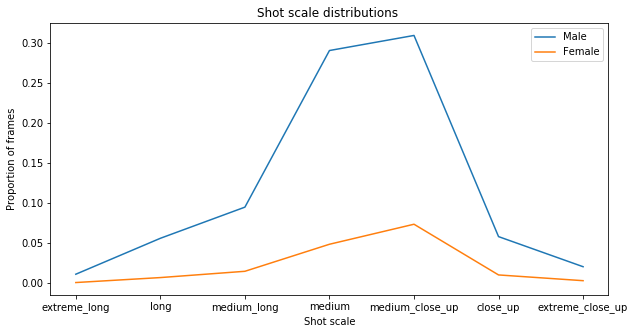

In [111]:
graph_shot_scale_distribution(
    shot_scale_labels,
    [shot_scale_distribution_all_videos_male, shot_scale_distribution_all_videos_female],
    ['Male', 'Female'],
    'Shot scale distributions '
)